## Query HRVPP catalogue and access data using the HRVPP S3 bucket

This notebook shows how to query the HRVPP catalogue service. The HRVPP catalogue service is an alternative for the WekEO HDA interface and implements a standardized [OpenSearch interface](http://docs.opengeospatial.org/is/17-047r1/17-047r1.html).
The catalogue service also comes with a [Python client](https://github.com/VITObelgium/terracatalogueclient), which allows for easy integration in Python notebooks and Python-based processing chains.

We'll also show how to access data using the HRVPP S3 bucket.

### Table of contents
* [Install & import packages](#install-import)
* [Discover collections](#discover-collections)
* [Search products](#search-products)
* [Access data](#access-data)

#### Install & import packages <a class="anchor" id="install-import"></a>

Let's start with installing the Python catalogue client.

In [22]:
!pip3 install --user --quiet --index-url=https://artifactory.vgt.vito.be/api/pypi/python-packages/simple terracatalogueclient==0.1.14

Next, we import some required packages and initialize the catalogue client. Make sure to select the HRVPP catalogue environment:

In [23]:
from terracatalogueclient import Catalogue
from terracatalogueclient.config import CatalogueConfig
from terracatalogueclient.config import CatalogueEnvironment

# make sure to retrieve config for the HRVPP catalogue
config = CatalogueConfig.from_environment(CatalogueEnvironment.HRVPP)
catalogue = Catalogue(config)

#### Discover collections <a class="anchor" id="discover-collections"></a>

We'll first query the available HRVPP collections. You'll see that we have one VI (Vegentation Index) collection in UTM projection and ST (Seasonal Trajectories) and VPP (Vegetation Phenology and Productivity parameters) in both UTM and LAEA projections:

In [24]:
import pandas as pd
collections = catalogue.get_collections()

rows = []
for c in collections:
    rows.append([c.id, c.properties['title']])
    
df = pd.DataFrame(data = rows, columns = ['Identifier', 'Description'])
df.style.set_properties(**{'text-align': 'left'})

,Identifier,Description
0,copernicus_r_3035_x_m_hrvpp-st_p_2017-now_v01,"Seasonal Trajectories, 10-daily, LAEA projection"
1,copernicus_r_3035_x_m_hrvpp-vpp_p_2017-now_v01,"Vegetation Phenology and Productivity parameters, yearly, LAEA projection"
2,copernicus_r_utm-wgs84_10_m_hrvpp-st_p_2017-now_v01,"Seasonal Trajectories, 10-daily, UTM projection"
3,copernicus_r_utm-wgs84_10_m_hrvpp-vi_p_2017-now_v01,"Vegetation Indices, daily, UTM projection"
4,copernicus_r_utm-wgs84_10_m_hrvpp-vpp_p_2017-now_v01,"Vegetation Phenology and Productivity parameters, yearly, UTM projection"


#### Search products <a class="anchor" id="search-products"></a>

Let's search for all 10 meter VPP parameters for LAEA tiles covering Belgium for year 2020.
Products are returned as a Python generator! If you want to be able to iterate over the results more than once, you can convert it to a list.
Mind that this will load all results in memory, which could be huge depending on the number of results returned!

Notice that we used the 'accessedFrom=S3' parameter to indicate that we want to retrieve S3 URLs.

In [25]:
import pandas
import datetime as dt

# LAEA tiles covering Belgium
be_tiles = ["E37N31", "E38N31", "E39N31", "E40N31", "E38N30", "E39N30", "E40N30", "E39N29", "E40N29"]

product_list = []
for tileId in be_tiles:
    products = catalogue.get_products(
        "copernicus_r_3035_x_m_hrvpp-vpp_p_2017-now_v01",
        start=dt.date(2020, 1, 1),
        end=dt.date(2020, 12, 31),
        tileId=tileId,
        accessedFrom="S3",
        productType="LENGTH",
        resolution=10
    )
    product_list.extend(list(products))

rows = []
for product in product_list:
    rows.append([product.id, product.data[0].href, (product.data[0].length/(1024*1024))])

df = pd.DataFrame(data = rows, columns = ['Identifier', 'URL', 'Size (MB)'])
df.style.set_properties(**{'text-align': 'left'})

,Identifier,URL,Size (MB)
0,VPP_2020_S2_E37N31-03035-010m_V101_s1_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_LENGTH.tif,31.4801
1,VPP_2020_S2_E37N31-03035-010m_V101_s2_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s2/VPP_2020_S2_E37N31-03035-010m_V101_s2_LENGTH.tif,14.5406
2,VPP_2020_S2_E38N31-03035-010m_V101_s1_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E38N31-03035-010m_V101_s1_LENGTH.tif,71.4706
3,VPP_2020_S2_E38N31-03035-010m_V101_s2_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s2/VPP_2020_S2_E38N31-03035-010m_V101_s2_LENGTH.tif,32.2428
4,VPP_2020_S2_E39N31-03035-010m_V101_s1_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E39N31-03035-010m_V101_s1_LENGTH.tif,110.806
5,VPP_2020_S2_E39N31-03035-010m_V101_s2_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s2/VPP_2020_S2_E39N31-03035-010m_V101_s2_LENGTH.tif,38.4902
6,VPP_2020_S2_E40N31-03035-010m_V101_s1_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E40N31-03035-010m_V101_s1_LENGTH.tif,115.381
7,VPP_2020_S2_E40N31-03035-010m_V101_s2_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s2/VPP_2020_S2_E40N31-03035-010m_V101_s2_LENGTH.tif,46.9858
8,VPP_2020_S2_E38N30-03035-010m_V101_s1_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E38N30-03035-010m_V101_s1_LENGTH.tif,112.263
9,VPP_2020_S2_E38N30-03035-010m_V101_s2_LENGTH,s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s2/VPP_2020_S2_E38N30-03035-010m_V101_s2_LENGTH.tif,45.3095


#### Access data <a class="anchor" id="access-data"></a>

Downloading the data would transfer > 1 GB to the notebook environment, which we don't want.

In [26]:
catalogue.download_products(product_list, '/tmp')

You are about to download 1.28 GB, do you want to continue? [Y/n] n


Instead, let's show that we can access the data using the S3 API.

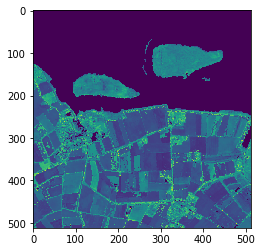

In [27]:
import boto3
import rasterio
from rasterio.session import AWSSession
from rasterio.windows import Window
from matplotlib import pyplot

# S3 credentials are not validated, but should be set:
s3_access_key = 'a'
s3_access_secret = 'b'
session = boto3.Session(aws_access_key_id=s3_access_key, aws_secret_access_key=s3_access_secret)

# select one product:lenght of season 1 for LAEA tile E39N31
s3_url = df['URL'][4]

# read part of the data using rasterio
with rasterio.Env(AWSSession(session), AWS_S3_ENDPOINT='data.cloudferro.com', AWS_HTTPS='NO', AWS_VIRTUAL_HOSTING='FALSE') as env:
    with rasterio.open('/vsis3/{}'.format(s3_url[5:]), 'r') as ds:
        array = ds.read(1, window=Window(0, 0, 512, 512))
        pyplot.imshow(array)
        pyplot.show()